**<h3> Grover Search Algorithm </h3>**

Objective: To search for an element in an unstructured database of $N\approx 2^n$ elements.

Classically it requires $O(N)$ queries to the database to find such an element, but there exists a quantum searching algorithm that can perform this task in $O(\sqrt{N})$ queries.

To setup the search space, we associate to each entry of the database, a basis state of the n-qubit space (which has $2^n$ orthogonal states).

Each grover iteration consists of two stage of operations:

- <b>In the query phase</b>, which changes(flips) the sign of the amplitude of the marked element in the list .

- <b>In the inversion phase</b>, the value of each element is reflected over the mean of all values i.e for each amplitude $ x $, the new value is calculated as $ mean - (x - mean) = 2mean -x $.

The operator in each phase is unitary (linear). The unitary matrix in the query phase depends on the input, 
but the unitary operator in the inversion phase does not depend on the input.

Initially we start with an equal superposition state where the amplitudes of all the states are same $\frac{1}{N}$ 
$$|u\rangle = \left(\frac{1}{N} ~~ \frac{1}{N} ~~ \cdots ~~ \frac{1}{N} \right)$$

For $ N $ elements with $ k $ marked ones, if the amplitudes of an unmarked and a marked elements are $ a $ and $ b $, respectively, then the quantum state can be represented as

$$ |\Psi\rangle = \sqrt{\frac{N-M}{N}} ~ \ket{unmarked} + \sqrt{\frac{M}{N}} ~ \ket{marked} $$ 

**<h5>Query Phase</h5>**

First of all we build the circuit for the Query phase. 

This operation reflects the sign of the amplitude of marked element. Essentially it performs a reflection over the axis made by the $\ket{unmarked}$ state.

This can be seen as:
$$
Q\ket{\Psi} = \sqrt{\frac{N-M}{N}} ~ \ket{unmarked} - \sqrt{\frac{M}{N}} ~ \ket{marked}
$$
where Q is the operator for the query phase.

We can define the problem of searching an element in terms of a search oracle $f(\mathbf{x})$ such that $f(\mathbf{x})=1$ if $\mathbf{x}$ is a marked state, and 0 otherwise.

Recall from phase kickback that if $\ket{y}=\ket{-} = \frac{1}{\sqrt{2}} (\ket{0} - \ket{1})$, then the operator $U_f$ corresponding to $f$ acts as:
$$
U_f \ket{x}\ket{y} = U_f \ket{x}\ket{-} = (-1)^{f(x)} \ket{x} \ket{-}
$$

Applying X and then H, puts $\ket{y}$ into $\ket{-}$ state. We apply X & H in reverse order finally at the end to undo the state of the ancilla.

For our case, let the marked state be $\ket{01}$, then the ancilla $f(x)$ should be 1 when $q_0 = 1$ and $q_1 = 0$. So we put an X gate in qubit 1 (q1). We undo the state of this qubit by applying another X to it at the end.

In [1]:
from qiskit_aer import AerSimulator, StatevectorSimulator, UnitarySimulator
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import math

In [2]:
def query1(circuit,q_reg,n,marked_elements):

    if(marked_elements[0]==0):
        circuit.x(q_reg[1])
        circuit.x(q_reg[2])
    elif(marked_elements[0]==1):
        circuit.x(q_reg[1])
    elif(marked_elements[0]==2):
        circuit.x(q_reg[2])


    circuit.ccx(q_reg[0],q_reg[1],q_reg[n])


    if(marked_elements[0]==0):
        circuit.x(q_reg[1])
        circuit.x(q_reg[2])
    elif(marked_elements[0]==1):
        circuit.x(q_reg[1])
    elif(marked_elements[0]==2):
        circuit.x(q_reg[2])

[1]


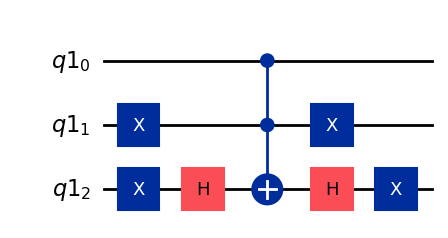

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0. -0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0. -0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]


In [3]:
N = 4
n = int(math.log2(N))
q_reg = QuantumRegister(n+1)      # 2 data qubits + 1 ancilla qubit
query_ckt = QuantumCircuit(q_reg)
#
##marked state will be marked by -1
## The elements are 00,01,10,11
## Here the 2nd element 01 is the marked state
marked = [1, -1, 1, 1]
marked_elements = [i for i in range(len(marked)) if marked[i]==-1]
print(marked_elements)

query_ckt.x(q_reg[n])
query_ckt.h(q_reg[n])
#
query1(query_ckt,q_reg,n,marked_elements)
#
#query_ckt.ccx(q_reg[0],q_reg[1],q_reg[2])
query_ckt.h(q_reg[n])
query_ckt.x(q_reg[n])
# No need to define classical register as we are not measuring

display(query_ckt.draw(output='mpl'))
job = UnitarySimulator().run(query_ckt)
u=job.result().get_unitary(query_ckt,decimals=3).data
print(u.real)

This circuit corresponds to the Query part, and it flips the sign of the amplitude of the marked state. 

As can be seen from the matrix representation of the circuit where the amplitude of the marked $|01\rangle$ is flipped.

The lower bottom block corresponds to the ancilla qubit whereas the first 4 block corresponds to the data qubits.

As an example, for a marked element of $\ket{11}$, we dont need to apply X gates to the data qubits q0 and q1.
for a marked element of $\ket{10}$, we dont need to apply X gate to the top data qubit q0.

Now, we need to incorporate this with the implementation of Inversion operator(conditional phase shift) to get the full Grover iterate.

**<h5>Inversion Phase</h5>**

The inversion term refers to the inversion about the mean. For each amplitude $ \mathbf{x} $, in list, it returns a new value:  $$ mean - (\mathbf{x} - mean) = 2mean -\mathbf{x} $$

**How do we implement the Inversion operator?**

We define an operator D (Diffusion operator)

$$ D = 2 \begin{pmatrix}
    \frac{1}{N}  & \cdots & \frac{1}{N} \\ 
    \vdots & \ddots & \vdots \\
    \frac{1}{N}  & \cdots & \frac{1}{N} \\ 
    \end{pmatrix}
- I . $$

we can see that is D is applied to an arbitrary state $(x_1 ~~ x_2 ~~ \cdots ~~ x_N)$, it performs an inversion about the mean $m = \dfrac{ \sum_{i=1}^N x_i } { N}$:


$ D \begin{pmatrix}x_1 \\ \vdots \\ x_N\end{pmatrix} = \begin{pmatrix}2m-x_1 \\ \vdots \\ 2m-x_N \end{pmatrix} $.

Therefore, inversion operation corresponds to the application of D on the state vector. 

It can be shown that D performs a reflection over the axis formed by the initial vector $|u\rangle$.

Given that $|u\rangle = \left(\frac{1}{N} ~~ \frac{1}{N} ~~ \cdots ~~ \frac{1}{N} \right)$ is an initial state,

$$D=2|u\rangle\langle u| - I$$

It can further be simplified down to:
\begin{align*}
D&=2|u\rangle\langle u| - I \\
&= 2H^{\otimes n}\ket{\mathbf{0}}\bra{\mathbf{0}}H^{\otimes n}-I \\
&= 2H^{\otimes n}\ket{\mathbf{0}}\bra{\mathbf{0}}H^{\otimes n}-H^{\otimes n}H^{\otimes n}\\
&=H^{\otimes n} (2\ket{\mathbf{0}}\bra{\mathbf{0}}H^{\otimes n}-H^{\otimes n}) \\
&=H^{\otimes n} (2\ket{\mathbf{0}}\bra{\mathbf{0}}-I)H^{\otimes n}
\end{align*}

Because of the presence of the Hadamards on both sides, we apply hadamard to each data qubits in the Inversion circuit part

$(2\ket{\mathbf{0}}\bra{\mathbf{0}}-I) \ket{x} = 2\ket{\mathbf{0}}\braket{\mathbf{0}}{x}-\ket{x} .$

If $\ket{x}=\ket{\mathbf{0}}$, since $\langle\mathbf{0}|\mathbf{0}\rangle=1$, then $2\ket{\mathbf{0}}\braket{\mathbf{0}}{\mathbf{0}}-\ket{\mathbf{0}} = 2\ket{\mathbf{0}}-\ket{\mathbf{0}} = \ket{\mathbf{0}}$.

If $\ket{x}\neq \ket{\mathbf{0}}$, since $\langle\mathbf{0}|\mathbf{x}\rangle=0$, then $2|\mathbf{0}\rangle \langle\mathbf{0}|\mathbf{x}\rangle-\ket{x}= 2\ket{\mathbf{0}}\cdot 0 -\ket{\mathbf{x}} = -\ket{\mathbf{x}}$.

The effect of $2\ket{\mathbf{0}}\bra{\mathbf{0}}-I$  is flipping the amplitude of any state except $\ket{\mathbf{0}}$.

Let us assume that the inverse of $|0\rangle\langle 0 | - I$ can be implemented by a function $f$ (represented by $U_f$) such that $U_f$ returns 1 if $|\mathbf{x}\rangle = 0$ and 0 if $|\mathbf{x}\rangle = 1$.



From phase kickback we know that given a function $g(0)=0$ and $g(1)=1$, $$U_g\left(|\mathbf{x}\rangle |-\rangle\right) = (-1)^{g(x)}\left(|\mathbf{x}\rangle |- \rangle\right)$$
where if $|\mathbf{x}\rangle = |0\rangle$, $U_g\left(|0\rangle |-\rangle\right) = |0\rangle |-\rangle$ ,

and if $|\mathbf{x}\rangle = |1\rangle$, $U_g\left(|1\rangle |-\rangle\right) = -|1\rangle |-\rangle$


We can see that for the following circuit of a toffoli gate, we get the output 1 only when the qubits values are $|11\rangle$.

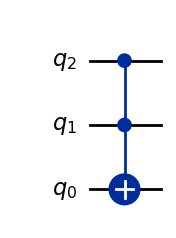

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [4]:
qc2 = QuantumCircuit(3)
qc2.ccx(2,1,0)
display(qc2.draw(output='mpl',reverse_bits=True))
job = UnitarySimulator().run(qc2)
result=job.result().get_unitary(qc2,decimals=2).data
print(result.real)

To actually implement $U_f$(that is the opposite of $U_g$), we should output 1 only when the qubits $\mathbf{x}$ are $\ket{\bf 0}$, that is we should apply $X$ gate to the control qubits, then apply the toffoli and finally undo the state of the qubits $\mathbf{x}$ by reapplying the X gate. 

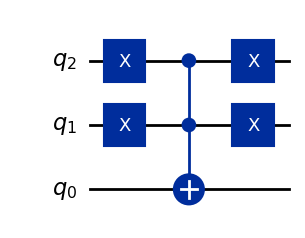

[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [5]:
qc = QuantumCircuit(3)
qc.x(2)
qc.x(1)
qc.ccx(2,1,0)
qc.x(2)
qc.x(1)
display(qc.draw(output='mpl',reverse_bits=True))
job = UnitarySimulator().run(qc)
result=job.result().get_unitary(qc,decimals=2).data
print(result.real)

What we have just obtained is the opposite of the behaviour obtained by the application of $(2\ket{\mathbf{0}}\bra{\mathbf{0}}-I)$ as seen above. 

Therefore to make the output is 1 when $x$ is not $\ket{\bf{0}}$ and the output is 0 otherwise, we apply $X$-gate to the ancila qubit.

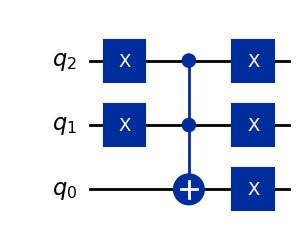

In [6]:
qc = QuantumCircuit(3)
qc.x(2)
qc.x(1)
qc.ccx(2,1,0)
qc.x(2)
qc.x(1)
qc.x(0)
display(qc.draw(output='mpl',reverse_bits=True))

Collecting everything together, we have the final circuit for the inversion phase as:

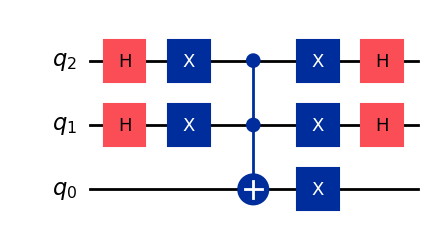

In [7]:
qc = QuantumCircuit(3)
qc.h([1,2])
qc.x(2)
qc.x(1)
qc.ccx(2,1,0)
qc.x(2)
qc.x(1)
qc.h([1,2])
qc.x(0)
display(qc.draw(output='mpl',reverse_bits=True))

**<h5>Quantum circuit for Grover's Search</h5>**

Now we build the entire Grover circuit (with one grover iteration). 

- Succesively applying two reflections to our quantum states, amplifies the amplitude of the marked state wheres as reduces the amplitudes of that of unmarked states.

- The first reflection (Query) is a clockwise rotation by $\theta$, and the second reflection is a counterclockwise rotation. 

- The second reflection always rotates $ 2 \theta $ degree more than the first reflection, where the $ \theta $ is the angle of this initial state on the unit circle.

- Therefore, the quantum state is rotated by $ 2 \theta $ in counter-clockwise direction after two reflections.

We first initialise the data qubits to uniform superposition and put together first, the Query circuit (which implements the oracle) and then the Inversion part of the circuit

**We are using the 2nd qubit as ancilla here**

In [8]:
def inversion(circuit,q_reg,n):


    #step 1
    circuit.h([i for i in range(n)])

    #step 2
    circuit.x([i for i in range(n)])

    if(n==2):
        circuit.ccx(q_reg[1],q_reg[0],q_reg[2])

    if(n==3):
        circuit.mcx([q_reg[0],q_reg[1],q_reg[2]],q_reg[n])

    #step 4
    circuit.x([i for i in range(n)])

    #step 5
    circuit.x(q_reg[n])

    #step 6
    circuit.h([i for i in range(n)])

#def query(circuit,q_reg,n):
#    circuit.x(q_reg[1])
#    circuit.ccx(q_reg[0],q_reg[1],q_reg[n-2])
#    grover_ckt.x(q_reg[1])

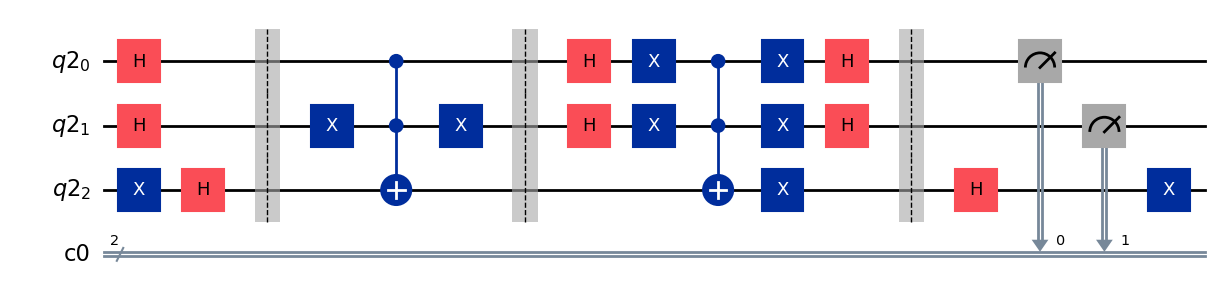

01 is observed 1000 times


In [9]:
N = 4
n = int(np.log2(N))
marked = [1, -1, 1, 1]
marked_elements = [i for i in range(len(marked)) if marked[i]==-1]
q_reg =  QuantumRegister(n+1)
c_reg = ClassicalRegister(n)

grover_ckt = QuantumCircuit(q_reg,c_reg)

grover_ckt.h([q_reg[i] for i in range(n)])

# set ancilla qubit
grover_ckt.x(q_reg[2])
grover_ckt.h(q_reg[2])
grover_ckt.barrier()

query1(grover_ckt,q_reg,n,marked_elements)
grover_ckt.barrier()
inversion(grover_ckt,q_reg,n)
grover_ckt.barrier()


# set ancilla qubit back
grover_ckt.h(q_reg[2])
grover_ckt.x(q_reg[2])

grover_ckt.measure([q_reg[i] for i in range(n)],[c_reg[i] for i in range(n)])
display(grover_ckt.draw(output='mpl'))

job = AerSimulator().run(grover_ckt,shots=1000)
counts_ = job.result().get_counts(grover_ckt)

# print the outcome
for outcome in counts_:
    print(outcome,"is observed",counts_[outcome],"times")

Hence, the marked element is found with one grover iteration in this case.

**<ins>Grover Search for N=8:</ins>**

Let us repeat the process for N=8 with one marked element.

As we perform grover iterations, the amplitudes of marked element keeps on increasing untill it reaches a maximum at some point, after which it starts decreasing. Therefore, we need to stop iterating after a certain no. of iterations.

For a single marked element, the number of Grover iterations needed which would maximise the probability to get the marked element is $\pi \frac{\sqrt{N}}{4}$.

In [10]:
def apply_X(circuit,n,marked_elements):
    if(marked_elements[0]==0):
        circuit.x([q_reg[i] for i in range(n)])
    elif(marked_elements[0]==1):
        circuit.x([q_reg[2],q_reg[1]])
    elif(marked_elements[0]==2):
        circuit.x([q_reg[2],q_reg[0]])
    elif(marked_elements[0]==3):
        circuit.x([q_reg[2]])
    elif(marked_elements[0]==4):
        circuit.x([q_reg[1],q_reg[0]])
    elif(marked_elements[0]==5):
        circuit.x([q_reg[1]])
    elif(marked_elements[0]==6):
        circuit.x([q_reg[0]])

def query2(circuit,q_reg,n,marked_element):

    apply_X(circuit,n,marked_elements)

    circuit.mcx([q_reg[0],q_reg[1],q_reg[2]],q_reg[n])

    apply_X(circuit,n,marked_elements)

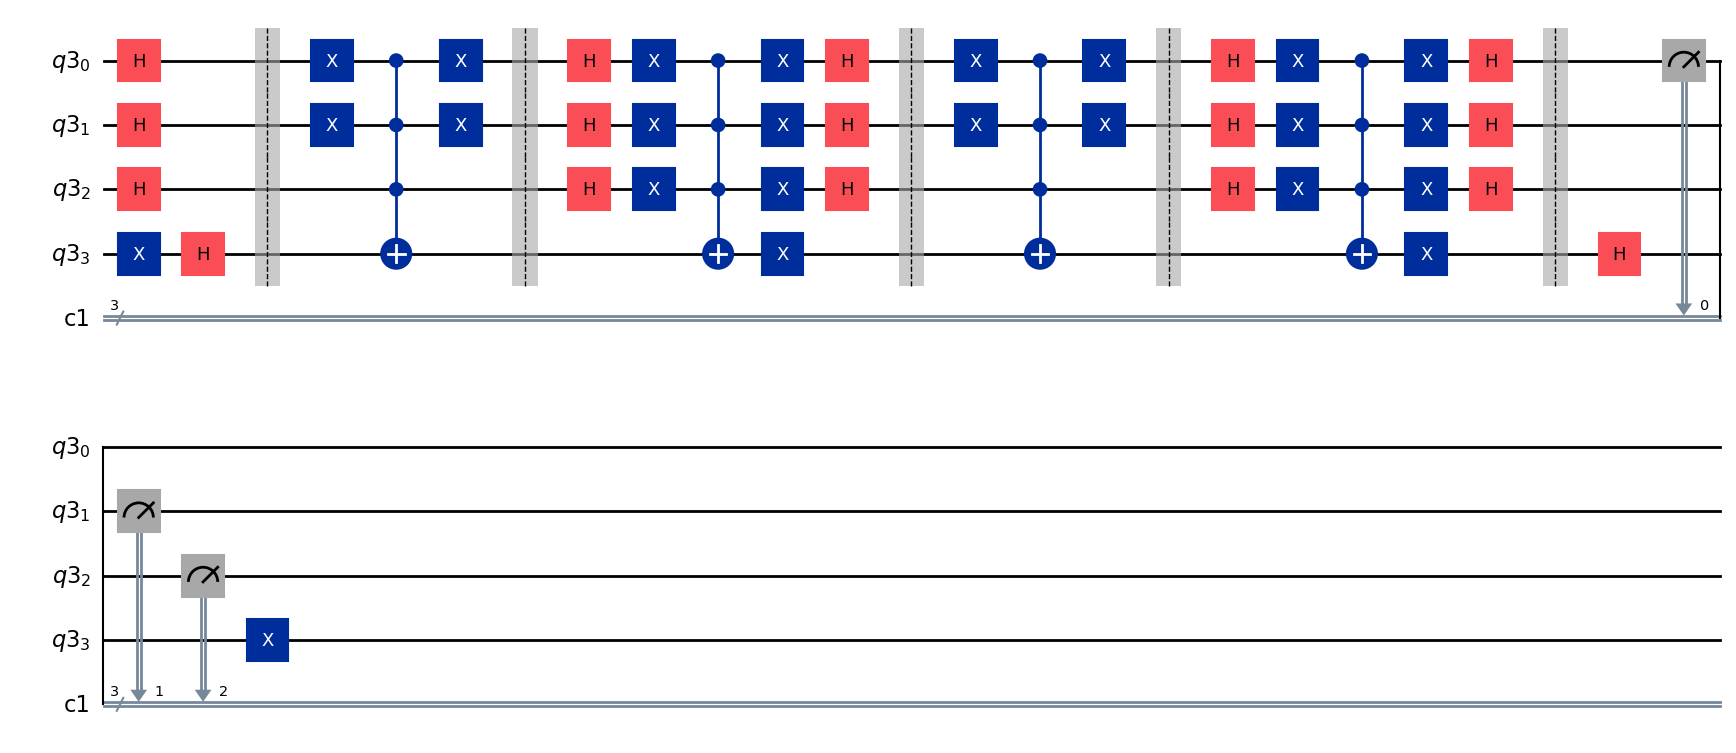

011 is observed 75 times
111 is observed 77 times
100 is observed 9440 times
001 is observed 93 times
110 is observed 78 times
010 is observed 74 times
000 is observed 80 times
101 is observed 83 times


In [11]:
N = 8
n = int(math.log2(N))
marked = [1,1,1,1,-1,1,1,1]
marked_elements = [i for i in range(len(marked)) if marked[i]==-1]

q_reg =  QuantumRegister(n+1)  # 3 data qubits + 1 ancilla qubits
c_reg = ClassicalRegister(n)

grover_ckt = QuantumCircuit(q_reg,c_reg)

grover_ckt.h([q_reg[i] for i in range(n)])

grover_ckt.x(q_reg[n])
grover_ckt.h(q_reg[n])
grover_ckt.barrier()

iterations = int(math.pi*math.sqrt(N)/4)
for iteration in range(iterations):
    query2(grover_ckt,q_reg,n,marked_elements)
    grover_ckt.barrier()
    inversion(grover_ckt,q_reg,n)
    grover_ckt.barrier()

grover_ckt.h(q_reg[n])
grover_ckt.x(q_reg[n])


grover_ckt.measure([q_reg[i] for i in range(n)],[c_reg[i] for i in range(n)])
display(grover_ckt.draw(output='mpl'))

job = AerSimulator().run(grover_ckt,shots=10000)
counts_ = job.result().get_counts(grover_ckt)

for outcome in counts_:
    print(outcome,"is observed",counts_[outcome],"times")


We get the maximum probability for the $|100\rangle$ state, which is the marked state.

Similar search process can be performed over a list of larger size and also to search for multiple marked elements in a list.